#Exploring Patterns of Population Structure and Environmental Associations to Aridity Across the Range of Loblolly Pine

##Introduction

In this set of analyses, we will be making use of data from the Eckert et al. 2010 paper to explore patterns of phenotypic and environmental associations among populations of loblolly pine.


###Abstract

Natural populations of forest trees exhibit striking phenotypic adaptations to diverse environmental
gradients, thereby making them appealing subjects for the study of genes underlying ecologically relevant phenotypes. Here, we use a genome-wide data set of single nucleotide polymorphisms genotyped across 3059 functional genes to study patterns of population structure and identify loci associated with aridity across the natural range of loblolly pine (Pinus taeda L.). Overall patterns of population structure, as inferred using principal components and Bayesian cluster analyses, were consistent with three genetic clusters likely resulting from expansions out of Pleistocene refugia located in Mexico and Florida. A novel application of association analysis, which removes the confounding effects of shared ancestry on correlations between genetic and environmental variation, identified five loci correlated with aridity. These loci were primarily involved with abiotic stress response to temperature and drought. A unique set of 24 loci was identified as FST outliers on the basis of the genetic clusters identified previously and after accounting for expansions out of Pleistocene refugia. These loci were involved with a diversity of physiological processes. Identification of nonoverlapping sets of loci highlights the fundamental differences implicit in the use of either method and suggests a pluralistic, yet complementary, approach to the identification of genes underlying ecologically relevant phenotypes.


##Overview of tasks

In general, what you will be doing is working your way from loading and saving data related to this study, to corrections for population structure, to looking for associations between genotypes and phenotypes, genotypes and the environment (`Bayenv2`), and genotypes+phenotypes+environment (`SQUAT`)

## This notebook

This notebook will walk you through getting SNP and phenotype associations, while correcting for population structure.  You will.

1. Remove the effect of population structure on the phenotype
1. Remove the effect of population structure on the genotype
1. Perform genotype-phenotype correlations for each SNP
1. Correct for multiple tests
1. Explore the full Patterson method (leave-one-out)

As with the previous notebook, execute the cell with the imports and continue

In [18]:
import os, sys
from IPython.display import Image
import pandas as pd
from __future__ import division
import numpy as np
import rpy2
from rpy2 import robjects as ro
import pandas.rpy.common as com
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import scipy as sp
import traceback
from sklearn import preprocessing
from IPython.parallel import Client
from subprocess import Popen, PIPE
import shutil
from IPython.display import FileLink, FileLinks, Image
import psutil
import multiprocessing
from hdfstorehelper import HDFStoreHelper
import warnings
import pandas
import dill
import statsmodels as sm
import statsmodels.formula.api as smf
from scipy.stats.stats import pearsonr
warnings.simplefilter("ignore", pandas.io.pytables.PerformanceWarning)
%matplotlib inline

%load_ext rpy2.ipython
pd.set_option('display.width', 80)
pd.set_option('max.columns', 30)

%load_ext autoreload
%autoreload 2

sns.set_context("talk")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
r = ro.r

In [20]:
%%R
library(qvalue)

In [21]:
hdf = HDFStoreHelper("data.hd5")

In [22]:
pca_drop_std = hdf.get("pca_drop_std")
pheno = hdf.get("pheno")
pca_cov = hdf.get("pca_cov")
trait_complete = hdf.get("trait_complete")

In [23]:
trait_complete_pca = trait_complete.join(pca_cov, how="inner").merge(pca_drop_std, 
                                                left_index=True, 
                                                right_index=True,
                                               suffixes = ('_hierf','_pca'))

In [24]:
trait_complete_pca

,Longitude,Latitude,fructose,county,state,lat,long,county_state,countyid,0-10037-01-257_hierf,0-10040-02-394_hierf,0-10044-01-392_hierf,0-10048-01-60_hierf,0-10051-02-166_hierf,0-10054-01-402_hierf,...,UMN-CL299Contig1-01-46_pca,UMN-CL306Contig1-04-261_pca,UMN-CL307Contig1-04-143_pca,UMN-CL319Contig1-03-131_pca,UMN-CL326Contig1-05-421_pca,UMN-CL339Contig1-05-39_pca,UMN-CL34Contig1-03-89_pca,UMN-CL353Contig1-04-64_pca,UMN-CL362Contig1-07-133_pca,UMN-CL363Contig1-01-233_pca,UMN-CL379Contig1-12-117_pca,UMN-CL424Contig1-03-94_pca,UMN-CL54Contig1-07-88_pca,UMN-CL91Contig1-02-246_pca,UMN-CL97Contig_pca
8,-78.70453,34.33010,5.824822,COLUMBUS,NC,34.33010,-78.70453,COLUMBUS_NC,11,NA,22,11,11,11,11,...,-0.141186,0.000000,1.064324,-0.506106,-0.580452,-0.225100,-0.774024,-0.044142,0.000000,-0.277861,-0.064989,0.729526,-0.904873,1.229051,2.434228
12,-79.30539,33.36318,5.958635,GEORGETOWN,SC,33.36318,-79.30539,GEORGETOWN_SC,14,NA,12,NA,NA,11,12,...,-0.141186,-0.388627,1.064324,0.000000,1.034360,-0.225100,0.000000,-0.044142,0.570407,-0.277861,-0.064989,-0.779494,0.000000,-0.472712,0.000000
13,-77.05205,35.55349,5.945595,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,11,NA,12,12,11,22,...,-0.141186,1.409903,-0.560743,-0.506106,-0.580452,-0.225100,-0.774024,-0.044142,0.570407,-0.277861,-0.064989,2.238546,-0.904873,1.229051,-0.679877
15,-77.06917,35.10917,5.872764,CRAVEN,NC,35.10917,-77.06917,CRAVEN_NC,12,12,12,12,12,11,12,...,-0.141186,-0.388627,-0.560743,-0.506106,-0.580452,-0.225100,0.740705,-0.044142,0.570407,1.686782,-0.064989,-0.779494,0.567087,-0.472712,-0.679877
18,-77.05205,35.55349,5.945595,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,11,11,22,11,12,12,...,-0.141186,-0.388627,-0.560743,-0.506106,-0.580452,1.899281,-0.774024,-0.044142,0.000000,-0.277861,-0.064989,0.729526,-0.904873,-0.472712,-0.679877
20,-77.06917,35.10917,5.872764,CRAVEN,NC,35.10917,-77.06917,CRAVEN_NC,12,11,12,12,22,11,22,...,-0.141186,-0.388627,1.064324,-0.506106,1.034360,-0.225100,0.740705,-0.044142,-0.900924,-0.277861,2.959514,-0.779494,0.567087,2.930814,-0.679877
21,-77.06917,35.10917,5.872764,CRAVEN,NC,35.10917,-77.06917,CRAVEN_NC,12,11,12,11,12,11,12,...,-0.141186,-0.388627,2.689391,1.165155,2.649172,-0.225100,-0.774024,-0.044142,0.570407,1.686782,-0.064989,0.729526,-0.904873,-0.472712,-0.679877
24,-77.06917,35.10917,5.872764,CRAVEN,NC,35.10917,-77.06917,CRAVEN_NC,12,11,22,11,11,11,12,...,-0.141186,3.208434,-0.560743,-0.506106,-0.580452,-0.225100,0.740705,-0.044142,-0.900924,-0.277861,-0.064989,0.729526,0.567087,-0.472712,-0.679877
25,-77.05205,35.55349,5.945595,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,11,12,NA,11,11,22,...,-0.141186,-0.388627,1.064324,-0.506106,1.034360,-0.225100,0.740705,-0.044142,0.570407,-0.277861,-0.064989,0.729526,-0.904873,-0.472712,-0.679877
26,-77.05205,35.55349,5.945595,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,11,11,11,11,11,12,...,-0.141186,-0.388627,1.064324,2.836416,-0.580452,1.899281,0.740705,-0.044142,0.570407,-0.277861,-0.064989,-0.779494,-0.904873,-0.472712,0.877175


In [25]:
trait_name = str(dill.load(open("trait_name.dill")))

In [26]:
pca_cols = [x for x in trait_complete_pca if 'PC' in x]
pca_cols
pca_cov_string = "+".join(pca_cols)
pca_cov_string

'PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10+PC11+PC12+PC13+PC14'

####Did you know that you can do linear regression in Python?  

Well, there's that plus much, much more.  Ready to abandon `R` yet?

The cell below runs a linear regression between the phenotype data with the PCA axes as covariates.  After you run the fit, check out the summary.  Notice anything?

In [27]:
"%s~%s" % (trait_name, pca_cov_string)

'fructose~PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10+PC11+PC12+PC13+PC14'

In [28]:
p_fit = smf.ols(formula="%s~%s" % (trait_name, pca_cov_string), 
                data=trait_complete_pca).fit()

In [29]:
p_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               fructose   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     3.252
Date:                Fri, 06 Mar 2015   Prob (F-statistic):           7.62e-05
Time:                        17:26:02   Log-Likelihood:                 363.81
No. Observations:                 330   AIC:                            -697.6
Df Residuals:                     315   BIC:                            -640.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      5.9022      0.005   1242.617      0.000         5.893     5.912
PC1            0.0013      0.001      1.282      0.201        -0.001     0.003
PC2            0.0012      0.001      0.852      0.395        -0.002     0.004
PC3           -0.0010      0.002     -0.656      0.512        -0.004     0.002
PC4            0.0020      0.002      1.345      0.179        -0.001     0.005
PC5           -0.0087      0.002     -5.364      0.000        -0.012    -0.006
PC6            0.0002      0.002      0.112      0.911        -0.003     0.004
PC7            0.0013      0.002      0.778      0.437        -0.002     0.005
PC8            0.0007      0.002      0.425      0.671        -0.003     0.004
PC9            0.0005      0.002      0.244      0.808        -0.003     0.004
PC10          -0.0037      0.002     -2.176      0.030        -0.007    -0.000
PC11           0.0002      0.002      0.135      0.893        -0.003     0.004
PC12          -0.0007      0.002     -0.455      0.650        -0.004     0.002
PC13           0.0035      0.002      1.870      0.062        -0.000     0.007
PC14          -0.0019      0.002     -1.100      0.272        -0.005     0.002
==============================================================================
Omnibus:                        8.567   Durbin-Watson:                   1.133
Prob(Omnibus):                  0.014   Jarque-Bera (JB):               11.767
Skew:                          -0.199   Prob(JB):                      0.00279
Kurtosis:                       3.835   Cond. No.                         5.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
p_fit.resid

8    -0.047639
12    0.041553
13    0.130172
15    0.004463
18    0.078926
20   -0.040417
21   -0.011436
24   -0.016964
25    0.078137
26    0.046170
27    0.020292
28    0.057557
29    0.080540
30    0.065253
31    0.052881
...
585   -0.024299
594   -0.015252
595   -0.038324
598    0.034978
599   -0.090449
600    0.050477
605   -0.064577
607   -0.022229
610    0.011269
612    0.016239
614    0.078471
615    0.117739
616    0.054250
617    0.104033
618    0.092842
Length: 330, dtype: float64

####Because we have to use this data in `R` later, let's make it friendly by fixing "-" and the fact that some SNPs start with numbers.

In [31]:
trait_complete_pca.columns = [x.replace("-", "_") if '_pca' in x else x for x in trait_complete_pca.columns]
trait_complete_pca.columns = ["X%s" % x if '_pca' in x else x for x in trait_complete_pca.columns]
trait_complete_pca.head()

,Longitude,Latitude,fructose,county,state,lat,long,county_state,countyid,0-10037-01-257_hierf,0-10040-02-394_hierf,0-10044-01-392_hierf,0-10048-01-60_hierf,0-10051-02-166_hierf,0-10054-01-402_hierf,...,XUMN_CL299Contig1_01_46_pca,XUMN_CL306Contig1_04_261_pca,XUMN_CL307Contig1_04_143_pca,XUMN_CL319Contig1_03_131_pca,XUMN_CL326Contig1_05_421_pca,XUMN_CL339Contig1_05_39_pca,XUMN_CL34Contig1_03_89_pca,XUMN_CL353Contig1_04_64_pca,XUMN_CL362Contig1_07_133_pca,XUMN_CL363Contig1_01_233_pca,XUMN_CL379Contig1_12_117_pca,XUMN_CL424Contig1_03_94_pca,XUMN_CL54Contig1_07_88_pca,XUMN_CL91Contig1_02_246_pca,XUMN_CL97Contig_pca
8,-78.70453,34.33010,5.824822,COLUMBUS,NC,34.33010,-78.70453,COLUMBUS_NC,11,NA,22,11,11,11,11,...,-0.141186,0.000000,1.064324,-0.506106,-0.580452,-0.225100,-0.774024,-0.044142,0.000000,-0.277861,-0.064989,0.729526,-0.904873,1.229051,2.434228
12,-79.30539,33.36318,5.958635,GEORGETOWN,SC,33.36318,-79.30539,GEORGETOWN_SC,14,NA,12,NA,NA,11,12,...,-0.141186,-0.388627,1.064324,0.000000,1.034360,-0.225100,0.000000,-0.044142,0.570407,-0.277861,-0.064989,-0.779494,0.000000,-0.472712,0.000000
13,-77.05205,35.55349,5.945595,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,11,NA,12,12,11,22,...,-0.141186,1.409903,-0.560743,-0.506106,-0.580452,-0.225100,-0.774024,-0.044142,0.570407,-0.277861,-0.064989,2.238546,-0.904873,1.229051,-0.679877
15,-77.06917,35.10917,5.872764,CRAVEN,NC,35.10917,-77.06917,CRAVEN_NC,12,12,12,12,12,11,12,...,-0.141186,-0.388627,-0.560743,-0.506106,-0.580452,-0.225100,0.740705,-0.044142,0.570407,1.686782,-0.064989,-0.779494,0.567087,-0.472712,-0.679877
18,-77.05205,35.55349,5.945595,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,11,11,22,11,12,12,...,-0.141186,-0.388627,-0.560743,-0.506106,-0.580452,1.899281,-0.774024,-0.044142,0.000000,-0.277861,-0.064989,0.729526,-0.904873,-0.472712,-0.679877


In [32]:
hdf.put("trait_complete_pca", trait_complete_pca)

updating trait_complete_pca


####Let's do those regressions

1. For each SNP, remove effect of pop structure
1. Correlate that SNPs residual's with the residuals of the phenotype
1. Rejoice.

This takes a minute or two on this data set.  If you have 100,000 SNPs in your data, go get a beer (or 5)

In [34]:
snp_num = 0
snp_cor = {}
for col in trait_complete_pca:
    if "_pca" in col:
        formula="%s ~ %s" % (str(col), pca_cov_string)
        g_fit = smf.ols(formula=formula, data=trait_complete_pca).fit()
        corrected = pearsonr(g_fit.resid, p_fit.resid)
        snp_cor[col] = corrected
        snp_num += 1
        if snp_num % 100 == 0:
            print "at %d" % snp_num

at 100
at 200
at 300
at 400
at 500
at 600
at 700
at 800
at 900
at 1000
at 1100
at 1200
at 1300
at 1400
at 1500
at 1600
at 1700
at 1800
at 1900
at 2000
at 2100
at 2200
at 2300
at 2400
at 2500
at 2600
at 2700
at 2800
at 2900
at 3000


####Let's store these so we don't have to run them later.  

In [35]:
snp_cor_df = pd.DataFrame(snp_cor, index=("r", "p")).T

In [37]:
snp_cor_df.head(20)

,r,p
X0_10037_01_257_pca,0.018725,0.734683
X0_10040_02_394_pca,-0.051914,0.347156
X0_10044_01_392_pca,-0.007962,0.885424
X0_10048_01_60_pca,-0.020802,0.706556
X0_10051_02_166_pca,-0.080218,0.145934
X0_10054_01_402_pca,0.054725,0.321639
X0_10067_03_111_pca,0.015799,0.774935
X0_10079_02_168_pca,0.114760,0.037187
X0_10112_01_169_pca,0.058606,0.288461
X0_10113_01_119_pca,-0.099102,0.072197


####We will use the Storey and Tibshirani (2003) method to correct for multiple tests using their `R` package available in `BioConductor`, `qvalue` 

In [38]:
def get_qvalues(pvalues):
    qvalue = r("qvalue")
    qobj = qvalue(pvalues)
    qvalues = qobj.rx2("qvalues")
    return np.array(qvalues)

In [39]:
q = get_qvalues(snp_cor_df.p)

In [40]:
snp_cor_df['q'] = q

In [41]:
snp_cor_df.head()

,r,p,q
X0_10037_01_257_pca,0.018725,0.734683,0.915733
X0_10040_02_394_pca,-0.051914,0.347156,0.885208
X0_10044_01_392_pca,-0.007962,0.885424,0.937755
X0_10048_01_60_pca,-0.020802,0.706556,0.911166
X0_10051_02_166_pca,-0.080218,0.145934,0.832102


####We can also get a description of a column in a `DataFrame`

In [42]:
snp_cor_df.q.describe()

count    3082.000000
mean        0.878836
std         0.060056
min         0.381939
25%         0.843889
50%         0.888018
75%         0.912929
max         0.944244
Name: q, dtype: float64

####This next bit of code is a bit complicated, but luckily you don't have to run it.

Patterson et al. suggest computing PCAs for each SNP such that the SNP that you're testing for association is not included in the data.  Can you think about why this might be the case?  Can you imagine how long this will take for large data sets.  A data set that I did this on for the talk I gave at Evolution 2014 was on about 79,000 SNPs and across 700 CPUs it still took about 6 hours.  

The code relies on IPython's parallel machinery to 

1. Set up a client to conenct to a cluster (after having started on)
1. Distributing the PCA function across the cluster
1. Running the jobs in parallel.  Caution here, if you have too many IPython engines running R processes, things sometimes crash.  No idea why.  Darn open source software.  I'm happy to talk about the code, but right now it's just here for reference.

```python
rc = Client(profile="gdcsrv2")
dview = rc[:]
lview = rc.load_balanced_view()
len(dview)
```

```python
def do_pca_in_parallel(locus):
    import os,sys
    sys.path.append("/gdc_home4/cfried/ipython/")
    os.environ['R_HOME'] = '/gdc_home4/cfried/R3/lib64/R'
    import rpy2.robjects as ro
    import pandas.rpy.common as com
    from pandas import DataFrame
    from hdfstorehelper import HDFStoreHelper
    hdf = HDFStoreHelper("/gdc_home5/groups/congenomics/day5/cfried/data.hd5")
    df = hdf.get("trait_complete_pca")
    r = ro.r
    prcomp = r('prcomp')
    df = df.ix[:,[x for x in df.columns if '_pca' in x]]
    df = df.drop(locus, axis=1)
    res = prcomp(com.convert_to_r_matrix(df), scale=False, center=False)
    x = com.convert_robj(res.rx2("x"))
    x.index = df.index
    return locus, x.ix[:,0:14].to_dict()

dview['do_pca_in_parallel'] = do_pca_in_parallel

pca_jobs = []
for col in trait_complete_pca:
    if "_pca" in col:
        job = lview.apply_async(do_pca_in_parallel, col)
        pca_jobs.append(job)
```

```python
ready = 0
pca_results = {}
for p in pca_jobs:
    if p.ready():
        res = p.r
        assert len(res) == 2
        pca_results[res[0]] = res[1]
        ready += 1
print ready, len(pca_jobs)

dill.dump(pca_results, open("pca_results.dill", "w"))

dill.dump(ols_results, open("ols_results.dill", "w"))

pca_results = dill.load(open("pca_results.dill"))

snp_num = 0
snp_cor2 = {}
for col in trait_complete_pca:
    if "_pca" in col:
        pca_cov2 = pd.DataFrame(pca_results[col])
        df = trait_complete_pca.merge(pca_cov2, how="inner", left_index=True,
                                     right_index=True, suffixes=('_x','_y'))
        pca_cov_string = "+".join(["%s_y" % x for x in pca_cov2.columns])
        formula="%s ~ %s" % (str(col), pca_cov_string)
        
        g_fit = smf.ols(formula=formula, data=df).fit()
        if snp_num % 100 == 0:
            print "at %d" % snp_num
        corrected = pearsonr(g_fit.resid, p_fit.resid)
        snp_cor2[col] = corrected
        snp_num += 1
        

snp_cor2_df = pd.DataFrame(snp_cor2, index=['r', 'p']).T
snp_cor2_df.head()
cors = snp_cor_df.merge(snp_cor2_df, how="inner", suffixes=['_1', '_2'], left_index=True, right_index=True)
hdf.put("snp_cor_df", snp_cor_df)
hdf.put("snp_cor2_df", snp_cor2_df)
hdf.put("cors", cors)
        
```

In [45]:
hdf2_file = "/gdc_home5/groups/congenomics/day5/cors.hdf"
hdf2 = HDFStoreHelper(hdf2_file)

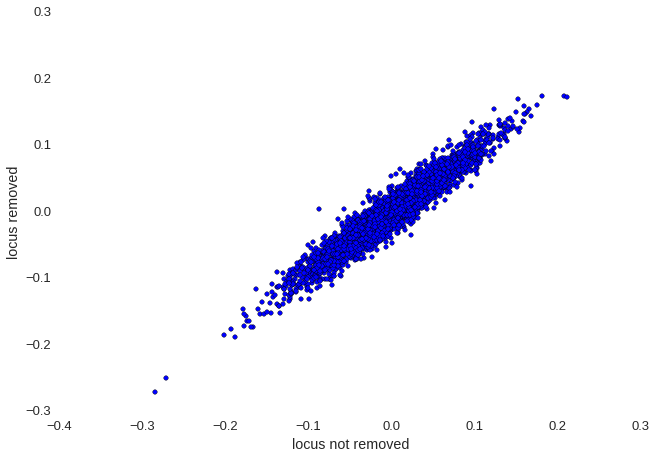

In [47]:
cors = hdf.get("cors")
plt.scatter(cors.r_1, cors.r_2)
plt.xlabel("locus not removed")
plt.ylabel("locus removed")
plt.show()


In [48]:
cors.head()

,r_1,p_1,sig,q,r_2,p_2
X0_10037_01_257_pca,-0.042362,0.443099,False,0.964207,-0.036227,0.511938
X0_10040_02_394_pca,-0.062683,0.256169,False,0.912507,-0.055956,0.310855
X0_10044_01_392_pca,-0.018156,0.742457,False,0.977601,-0.032281,0.558995
X0_10048_01_60_pca,-0.073602,0.182277,False,0.861624,-0.079781,0.148150
X0_10051_02_166_pca,0.135985,0.013420,False,0.648732,0.118151,0.031898


In [49]:
q2 = get_qvalues(cors["p_2"])
cors["q2"] = q2

In [50]:
cors[cors.q < 0.05]

,r_1,p_1,sig,q,r_2,p_2,q2
X0_16849_03_97_pca,-0.284650,0.000000,True,0.000443,-0.270562,0.000001,0.001864
XUMN_2809_01_235_pca,-0.271345,0.000001,True,0.000862,-0.249126,0.000005,0.007136


####How many SNPs are significantly correlated to your phenotype?

In [53]:
hdf.put("cors", cors)

updating cors
